# Indonesia QRIS Payment Behavior & Churn Analysis

This notebook analyzes customer behavior and behavioral churn patterns in a digital payment ecosystem, framed in the context of Indonesia’s QRIS payment infrastructure.

Because real transaction-level data from Indonesian e-wallet providers (e.g., GoPay, OVO, DANA, ShopeePay) is proprietary, this project uses a public anonymized/synthetic transaction dataset and maps payment rails into Indonesia-relevant categories (QRIS bank-based, QRIS wallet-based, and non-QRIS cards).

The goal is to answer:
- Do churn rates differ between QRIS-based payments and non-QRIS card payments?
- Is churn driven more by low engagement or low transaction value?
- How do activity and churn dynamics change over time?


## 1. Business Context (Indonesia + QRIS)

QRIS (Quick Response Code Indonesian Standard) is Indonesia’s unified QR code payment system. In practice, consumers can pay via QRIS using either:
- Bank-based apps (mobile banking) → funds come from bank accounts
- Wallet-based apps (e-wallet balances) → funds come from stored value

To reflect this reality, this analysis recodes raw payment methods into:
- QRIS (Bank-based)
- QRIS (Wallet-based)
- Non-QRIS (Cards)

This mapping is used as an analytical proxy (not a claim of proprietary provider data).


## 2. Churn Definition

This is a non-subscription payment context, so churn is defined behaviorally:

**A user is considered churned if they have no transactions in the last 90 days of the observation window.**

This is a common approach in fintech and e-commerce analytics when explicit cancellations do not exist.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Business pastel palette (defined, executive)
PALETTE = {
    "blue": "#4C72B0",      # primary (trust, fintech)
    "teal": "#55A868",      # secondary (growth)
    "orange": "#DD8452",    # accent (risk / churn)
    "purple": "#8172B2",    # supporting
    "gray": "#3A3A3A",
    "light_grid": "#EAEAEA"
}

mpl.rcParams.update({
    # Figure
    "figure.figsize": (10, 5),
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.facecolor": "white",

    # Fonts (clean & professional)
    "font.family": "DejaVu Sans",
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 12,

    # Axes & grid
    "axes.facecolor": "white",
    "axes.edgecolor": "white",
    "axes.grid": True,
    "grid.color": PALETTE["light_grid"],
    "grid.linewidth": 1.0,

    # Ticks
    "xtick.color": PALETTE["gray"],
    "ytick.color": PALETTE["gray"],
    "xtick.major.size": 0,
    "ytick.major.size": 0,

    # Legend
    "legend.frameon": False,

    # Lines
    "lines.linewidth": 2.8,
    "lines.markersize": 6,
})

pd.set_option("display.max_columns", None)


In [2]:
def prettify(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, loc="left", pad=14, fontweight="bold")
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=10)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=10)

    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

    ax.grid(axis="y")
    ax.grid(axis="x", visible=False)
    return ax

## 3. Data Loading

In [5]:
df = pd.read_csv("data/raw/digital_wallet_transactions.csv")

df.head()

,idx,transaction_id,user_id,transaction_date,product_category,product_name,merchant_name,product_amount,transaction_fee,cashback,loyalty_points,payment_method,transaction_status,merchant_id,device_type,location
0,1,4dac3ea3-6492-46ec-80b8-dc45c3ad0b14,USER_05159,2023-08-19 03:32,Rent Payment,2BHK Flat Deposit,Airbnb,1525.39,36.69,19.19,186,Debit Card,Successful,MERCH_0083,iOS,Urban
1,2,a903ed9f-eb84-47e7-b8aa-fd1786c919cf,USER_07204,2023-08-19 04:37,Gas Bill,Commercial Gas Connection,Adani Gas,1495.40,28.19,89.99,182,UPI,Successful,MERCH_0163,iOS,Urban
2,3,2a393013-733c-4add-9f09-bed1eeb33676,USER_00903,2023-08-19 05:52,Bus Ticket,Semi-Sleeper,MakeMyTrip Bus,1267.71,11.36,95.70,994,UPI,Successful,MERCH_0320,iOS,Urban
3,4,9a07ad19-4673-4794-9cd2-9b139f39c715,USER_01769,2023-08-19 06:35,Internet Bill,4G Unlimited Plan,Airtel Broadband,9202.63,6.41,82.24,409,Debit Card,Successful,MERCH_0194,Android,Urban
4,5,76418260-c985-4011-979d-0914604d0d68,USER_03544,2023-08-19 06:36,Loan Repayment,Home Loan EMI,Axis Bank,3100.58,41.15,40.47,837,Debit Card,Successful,MERCH_0504,Android,Urban


In [6]:
df.shape, df.columns.tolist()

((5000, 16),
 ['idx',
  'transaction_id',
  'user_id',
  'transaction_date',
  'product_category',
  'product_name',
  'merchant_name',
  'product_amount',
  'transaction_fee',
  'cashback',
  'loyalty_points',
  'payment_method',
  'transaction_status',
  'merchant_id',
  'device_type',
  'location'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 5000 non-null   int64  
 1   transaction_id      5000 non-null   object 
 2   user_id             5000 non-null   object 
 3   transaction_date    5000 non-null   object 
 4   product_category    5000 non-null   object 
 5   product_name        5000 non-null   object 
 6   merchant_name       5000 non-null   object 
 7   product_amount      5000 non-null   float64
 8   transaction_fee     5000 non-null   float64
 9   cashback            5000 non-null   float64
 10  loyalty_points      5000 non-null   int64  
 11  payment_method      5000 non-null   object 
 12  transaction_status  5000 non-null   object 
 13  merchant_id         5000 non-null   object 
 14  device_type         5000 non-null   object 
 15  location            5000 non-null   object 
dtypes: flo

## 4. Data Cleaning & Validation

We validate and standardize key columns needed for time-based and user-level analysis:
- Ensure `transaction_date` is parsed as datetime
- Validate the observation window (min/max dates)
- Confirm key columns exist


In [8]:
required_cols = ["transaction_id", "user_id", "transaction_date", "payment_method", "product_amount"]

missing = [c for c in required_cols if c not in df.columns]
missing


[]

In [9]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

df["transaction_date"].min(), df["transaction_date"].max()


(Timestamp('2023-08-19 03:32:00'), Timestamp('2024-08-18 01:15:00'))

In [10]:
df[["transaction_id", "user_id", "transaction_date", "payment_method", "product_amount"]].isna().sum()


transaction_id      0
user_id             0
transaction_date    0
payment_method      0
product_amount      0
dtype: int64

In [11]:
df = df.dropna(subset=["transaction_id", "user_id", "transaction_date", "payment_method", "product_amount"]).copy()

df.shape


(5000, 16)

## 5. Feature Engineering (QRIS Mapping)

The dataset contains generic payment rails (e.g., bank transfer, cards, UPI, wallet balance).  
To contextualize this within Indonesia:

- Bank Transfer → **QRIS (Bank-based)**
- UPI + Wallet Balance → **QRIS (Wallet-based)** (proxy for e-wallet QR flows / stored value usage)
- Debit/Credit Card → **Non-QRIS (Cards)**

This mapping is a structural proxy to analyze behavior across Indonesia-relevant payment categories.


In [12]:
df["payment_method"].value_counts()

payment_method
Bank Transfer     1045
Debit Card        1022
UPI                999
Credit Card        992
Wallet Balance     942
Name: count, dtype: int64

In [13]:
payment_map = {
    "Bank Transfer": "QRIS (Bank-based)",
    "UPI": "QRIS (Wallet-based)",
    "Wallet Balance": "QRIS (Wallet-based)",
    "Debit Card": "Non-QRIS (Cards)",
    "Credit Card": "Non-QRIS (Cards)"
}

df["payment_category"] = df["payment_method"].map(payment_map)

df["payment_category"].value_counts(dropna=False)


payment_category
Non-QRIS (Cards)       2014
QRIS (Wallet-based)    1941
QRIS (Bank-based)      1045
Name: count, dtype: int64

In [14]:
unmapped = df.loc[df["payment_category"].isna(), "payment_method"].value_counts()
unmapped


Series([], Name: count, dtype: int64)

## 6. Churn Label Creation

We compute churn at the **user level**:
1. Find each user's last transaction date
2. Define the churn cutoff = (dataset end date - 90 days)
3. Label users as churned if last transaction date < cutoff
4. Merge churn labels back into the transaction-level dataframe


In [15]:
user_last_tx = (
    df.groupby("user_id")["transaction_date"]
      .max()
      .reset_index()
      .rename(columns={"transaction_date": "last_transaction_date"})
)

user_last_tx.head()


,user_id,last_transaction_date
0,USER_00001,2024-05-28 18:36:00
1,USER_00002,2023-11-02 17:10:00
2,USER_00019,2024-03-17 10:13:00
3,USER_00020,2023-12-06 23:24:00
4,USER_00025,2024-06-12 01:06:00


In [16]:
data_end_date = df["transaction_date"].max()
churn_cutoff_date = data_end_date - pd.Timedelta(days=90)

data_end_date, churn_cutoff_date

(Timestamp('2024-08-18 01:15:00'), Timestamp('2024-05-20 01:15:00'))

In [17]:
user_last_tx["is_churned"] = user_last_tx["last_transaction_date"] < churn_cutoff_date

user_last_tx["is_churned"].value_counts()


is_churned
True     2740
False    1192
Name: count, dtype: int64

In [18]:
df = df.merge(user_last_tx[["user_id", "is_churned"]], on="user_id", how="left")

df["is_churned"].isna().sum(), df.shape


(np.int64(0), (5000, 18))

## 7. Analysis

### 7.1 Churn by Payment Category

We compare churn rates across Indonesia-framed payment categories (QRIS vs non-QRIS cards).
Churn rate is computed as the mean of the boolean `is_churned` (True=1, False=0).


In [19]:
churn_by_payment = (
    df.groupby("payment_category")["is_churned"]
      .mean()
      .sort_values(ascending=False)
)

(churn_by_payment * 100).round(2)


payment_category
Non-QRIS (Cards)       66.98
QRIS (Wallet-based)    64.66
QRIS (Bank-based)      63.92
Name: is_churned, dtype: float64

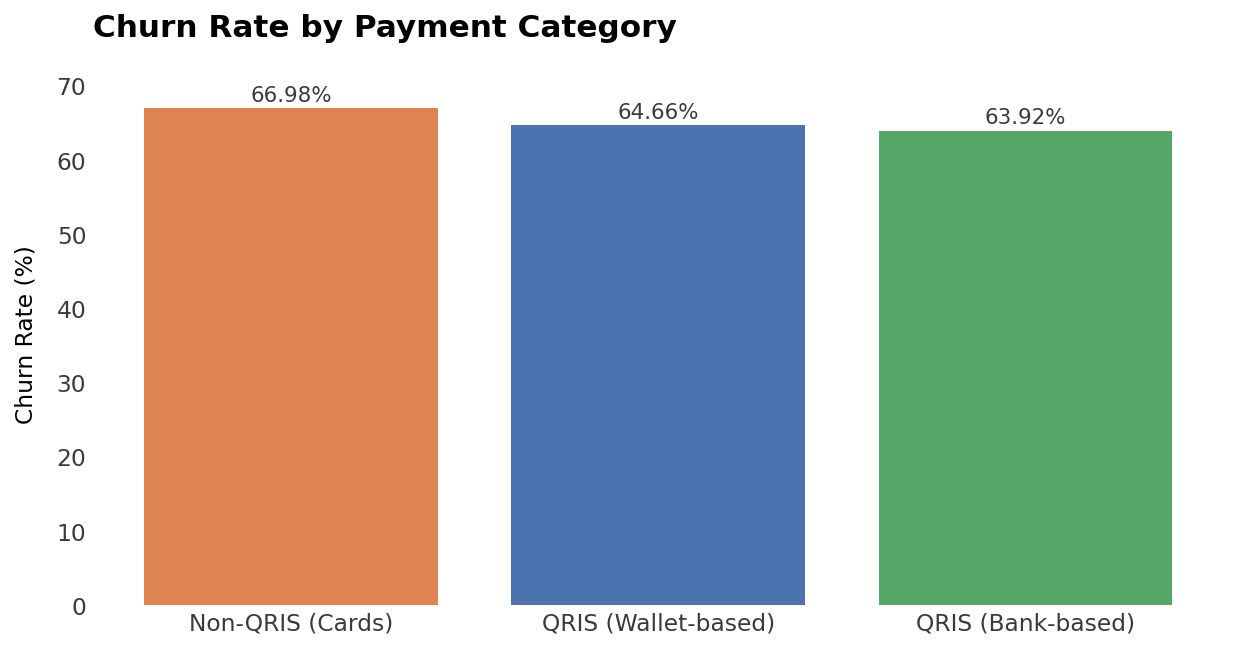

In [20]:
churn_pct = (churn_by_payment * 100).sort_values(ascending=False)

colors = [
    PALETTE["orange"],   # highest churn (attention)
    PALETTE["blue"],
    PALETTE["teal"]
]

fig, ax = plt.subplots(figsize=(9, 4.8))
bars = ax.bar(churn_pct.index, churn_pct.values, color=colors)

prettify(ax, title="Churn Rate by Payment Category", ylabel="Churn Rate (%)")

for b in bars:
    ax.text(
        b.get_x() + b.get_width()/2,
        b.get_height() + 0.4,
        f"{b.get_height():.2f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        color=PALETTE["gray"]
    )

ax.set_ylim(0, max(churn_pct.values) + 6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Takeaway:** QRIS-based payment categories show slightly lower churn than non-QRIS card payments, suggesting QR-based flows may be more embedded in routine usage.


### 7.2 Engagement vs Churn

We measure engagement using transactions per user and compare active vs churned users.


In [21]:
user_tx = (
    df.groupby("user_id")
      .agg(
          total_transactions=("transaction_id", "count"),
          is_churned=("is_churned", "first")
      )
      .reset_index()
)

user_tx.head()

,user_id,total_transactions,is_churned
0,USER_00001,1,False
1,USER_00002,1,True
2,USER_00019,2,True
3,USER_00020,1,True
4,USER_00025,1,False


In [22]:
user_tx.groupby("is_churned")["total_transactions"].mean()

is_churned
False    1.449664
True     1.194161
Name: total_transactions, dtype: float64

**Takeaway:** Active users complete more transactions on average than churned users, indicating churn is primarily associated with lower engagement (frequency), not necessarily lower spending.


### 7.3 Value vs Churn

We evaluate transaction value differences across payment categories and churn status.


In [23]:
df.groupby("payment_category")["product_amount"].mean().sort_values(ascending=False)

payment_category
QRIS (Bank-based)      4993.437311
Non-QRIS (Cards)       4988.655621
QRIS (Wallet-based)    4905.831633
Name: product_amount, dtype: float64

In [24]:
df.groupby("is_churned")["product_amount"].mean()

is_churned
False    4986.776152
True     4942.042916
Name: product_amount, dtype: float64

In [25]:
(
    df.groupby(["payment_category", "is_churned"])["product_amount"]
      .mean()
      .unstack()
)

is_churned,False,True
payment_category,,
Non-QRIS (Cards),4966.218286,4999.716279
QRIS (Bank-based),5011.617984,4983.176662
QRIS (Wallet-based),4993.052551,4858.155498


**Takeaway:** Transaction values are broadly similar across categories and churn status, implying churn is more driven by frequency/engagement than transaction size.

### 7.4 Engagement Distribution (Repeat Usage)

We inspect the distribution of transactions per user. This helps determine whether retention is driven by a small segment of repeat users or broad habitual usage.

In [26]:
user_tx["total_transactions"].describe()

count    3932.000000
mean        1.271617
std         0.540855
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: total_transactions, dtype: float64

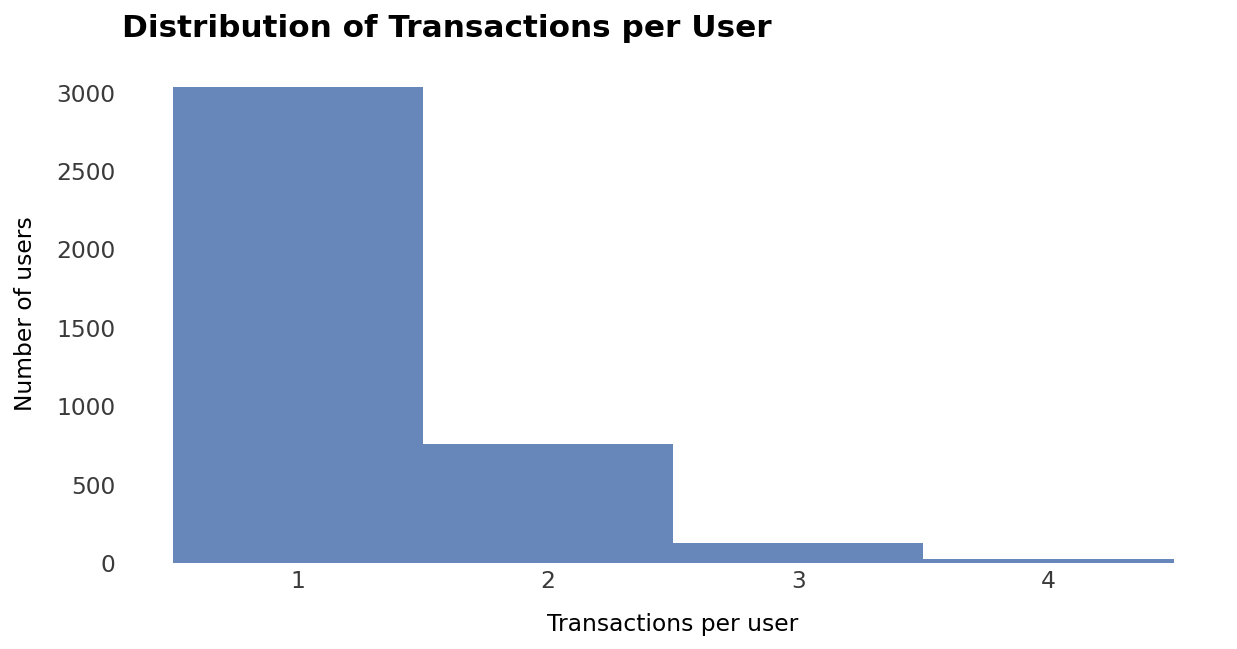

In [27]:
fig, ax = plt.subplots(figsize=(9, 4.8))
ax.hist(
    user_tx["total_transactions"],
    bins=range(1, int(user_tx["total_transactions"].max()) + 2),
    align="left",
    color=PALETTE["blue"],
    alpha=0.85
)

prettify(
    ax,
    title="Distribution of Transactions per User",
    xlabel="Transactions per user",
    ylabel="Number of users"
)

ax.set_xticks(sorted(user_tx["total_transactions"].unique()))
plt.tight_layout()
plt.show()

In [28]:
user_payment_mode = (
    df.groupby("user_id")["payment_category"]
      .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])
      .reset_index()
      .rename(columns={"payment_category": "payment_category_mode"})
)

user_tx2 = user_tx.merge(user_payment_mode, on="user_id", how="left")

(
    user_tx2.groupby(["payment_category_mode", "is_churned"])["total_transactions"]
           .agg(["count", "mean", "median"])
           .sort_values("count", ascending=False)
)

,,count,mean,median
payment_category_mode,is_churned,,,
Non-QRIS (Cards),True,1252,1.274760,1.0
QRIS (Wallet-based),True,932,1.098712,1.0
QRIS (Bank-based),True,556,1.172662,1.0
Non-QRIS (Cards),False,555,1.540541,1.0
QRIS (Wallet-based),False,382,1.298429,1.0
QRIS (Bank-based),False,255,1.478431,1.0


**Takeaway:** The median transactions per user is typically 1, meaning most users transact only once. Retention improvements are likely driven by incremental increases in repeat usage rather than creating high-frequency “power users.”

### 7.5 Time Trends (Monthly)

We analyze monthly activity to understand whether the ecosystem is stable, growing, or declining over time.
Metrics:
- Monthly total transactions
- Monthly active users
- Monthly total value
- Monthly active users by payment category
- Monthly churn share (share of transactions from users who eventually churn)

In [29]:
df["year_month"] = df["transaction_date"].dt.to_period("M").astype(str)
df[["transaction_date", "year_month"]].head()

,transaction_date,year_month
0,2023-08-19 03:32:00,2023-08
1,2023-08-19 04:37:00,2023-08
2,2023-08-19 05:52:00,2023-08
3,2023-08-19 06:35:00,2023-08
4,2023-08-19 06:36:00,2023-08


In [30]:
monthly = (
    df.groupby("year_month")
      .agg(
          total_transactions=("transaction_id", "count"),
          active_users=("user_id", "nunique"),
          total_value=("product_amount", "sum")
      )
      .reset_index()
)

monthly.head()

,year_month,total_transactions,active_users,total_value
0,2023-08,168,168,807940.29
1,2023-09,418,408,1948436.01
2,2023-10,420,409,2046460.22
3,2023-11,400,395,2007921.96
4,2023-12,428,419,2156513.62


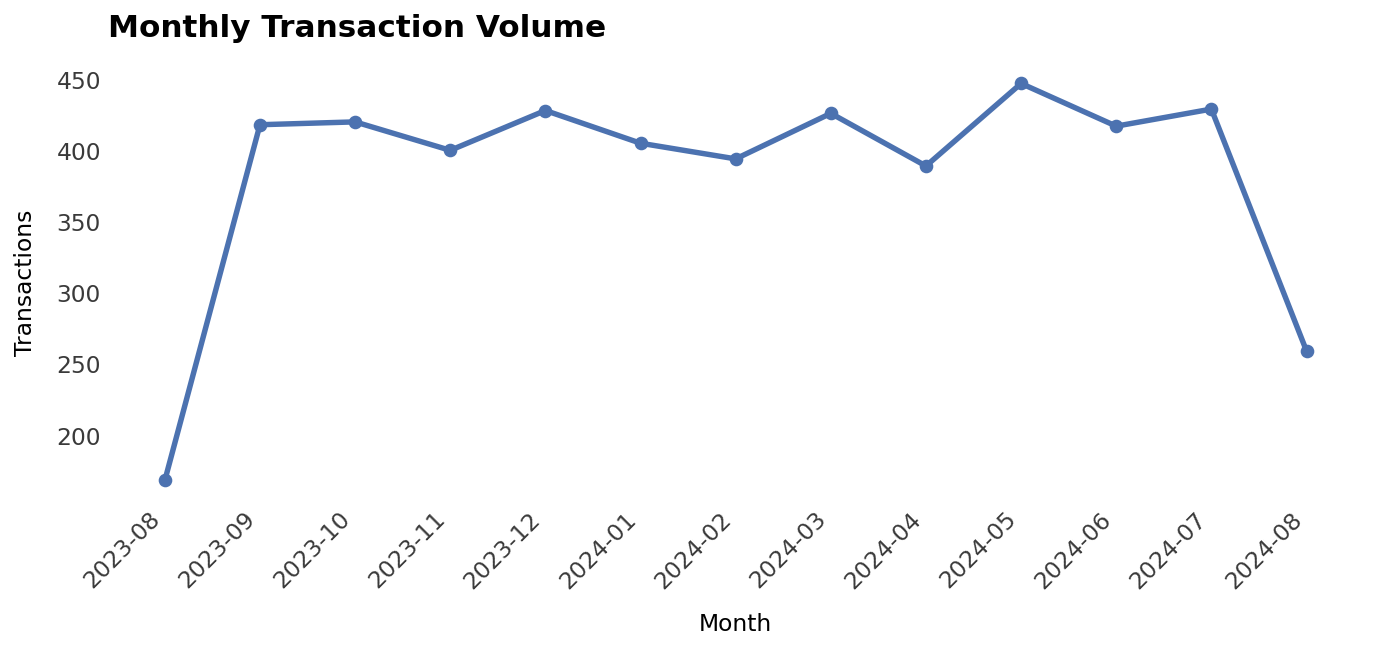

In [31]:
fig, ax = plt.subplots(figsize=(10, 4.8))
ax.plot(
    monthly["year_month"],
    monthly["total_transactions"],
    marker="o",
    color=PALETTE["blue"]
)

prettify(ax, title="Monthly Transaction Volume", xlabel="Month", ylabel="Transactions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

NameError: name 'pivot_mau' is not defined

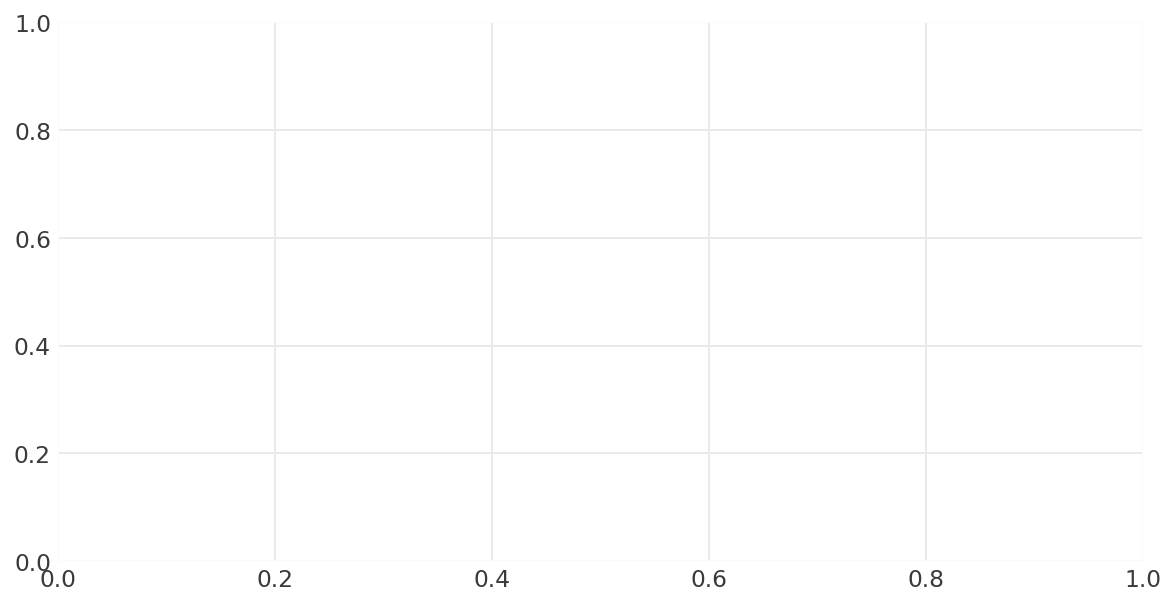

In [33]:
palette = {
    "QRIS (Bank-based)": PALETTE["blue"],
    "QRIS (Wallet-based)": PALETTE["teal"],
    "Non-QRIS (Cards)": PALETTE["orange"]
}

fig, ax = plt.subplots(figsize=(10, 5))
for col in pivot_mau.columns:
    ax.plot(
        pivot_mau.index,
        pivot_mau[col],
        marker="o",
        label=col,
        color=palette.get(col, PALETTE["purple"])
    )

prettify(
    ax,
    title="Monthly Active Users by Payment Category",
    xlabel="Month",
    ylabel="Active Users"
)

plt.xticks(rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

In [34]:
monthly_churn_share = (
    df.groupby("year_month")["is_churned"]
      .mean()
      .reset_index(name="churn_share")
)

monthly_churn_share.head()

,year_month,churn_share
0,2023-08,0.863095
1,2023-09,0.861244
2,2023-10,0.907143
3,2023-11,0.842500
4,2023-12,0.892523


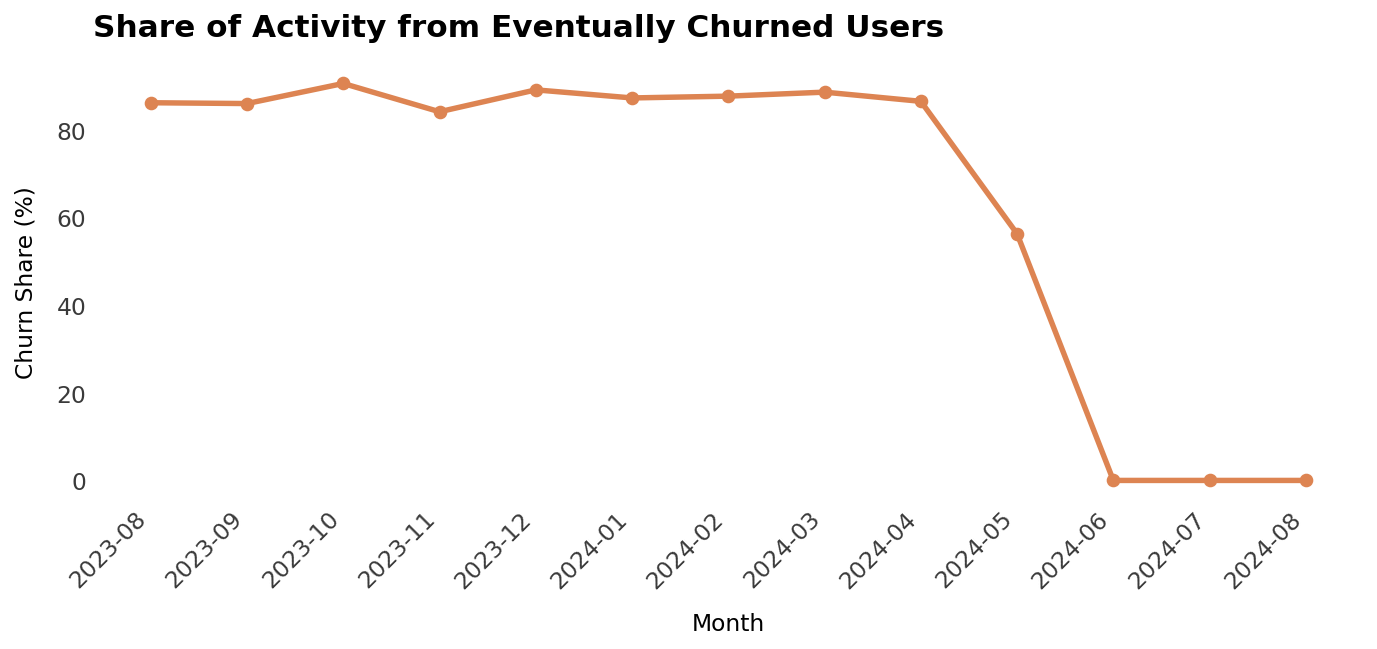

In [52]:
fig, ax = plt.subplots(figsize=(10, 4.8))
ax.plot(
    monthly_churn_share["year_month"],
    monthly_churn_share["churn_share"] * 100,
    marker="o",
    color=PALETTE["orange"]
)

prettify(
    ax,
    title="Share of Activity from Eventually Churned Users",
    xlabel="Month",
    ylabel="Churn Share (%)"
)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 8. Key Insights & Business Implications

1) **Churn is primarily engagement-driven.** Active users transact more often than churned users, even though transaction values are similar.

2) **QRIS-based payments are slightly “stickier.”** QRIS (bank-based and wallet-based) show marginally lower churn than non-QRIS card payments.

3) **Most users are low-frequency.** The median transactions per user is typically 1, meaning retention improvements likely come from nudging second/third transactions rather than building power users.

4) **Trends appear stable over time.** Monthly activity does not show extreme volatility, implying churn is more structural/behavioral than event-driven.

### Practical implications (what a payments team might do)
- Focus on **post-first-transaction activation**: nudges, reminders, “next purchase” incentives.
- Improve QRIS habit formation: merchant coverage, smoother QR checkout, targeted wallet-based QRIS promos.
- Monitor leading indicators: early repeat usage (e.g., second transaction within 7/14 days).

## 9. Limitations & Assumptions

- This project uses a public anonymized/synthetic transaction dataset and does not represent proprietary data from specific Indonesian payment providers.
- Payment rails were recoded into Indonesia-relevant QRIS categories to reflect Indonesia’s payment infrastructure and to support comparative behavioral analysis.
- Churn is defined as 90-day inactivity within a fixed observation window. Different churn windows (e.g., 60/120 days) may change absolute churn rates.
- User-level payment behavior can involve multiple methods; for user-level segmentation, a simple dominant-category (mode) proxy was used.

## 10. Next Steps

If this were extended into a stronger business project:
- Add **cohort retention** (first transaction month → retention over subsequent months)
- Build a small **dashboard** showing MAU, churn share, and QRIS adoption trends
- Segment by **merchant_category** (if available) to see which usage contexts drive retention
- Test sensitivity of churn to different inactivity windows (60 vs 90 vs 120 days)

In [51]:
import pandas as pd
from pathlib import Path

RAW_PATH = Path("data/raw/digital_wallet_transactions.csv")
if not RAW_PATH.exists():
    RAW_PATH = Path("digital_wallet_transactions.csv")

OUT_PATH = Path("data/processed/dashboard_data.csv")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(RAW_PATH)
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
df["transaction_id"] = df["transaction_id"].astype("string").str.strip()
df["user_id"] = df["user_id"].astype("string").str.strip()
df["payment_method"] = df["payment_method"].astype("string").str.strip()
df["product_amount"] = pd.to_numeric(df["product_amount"], errors="coerce")
df = df.dropna(subset=["transaction_id", "user_id", "transaction_date", "payment_method", "product_amount"]).copy()

payment_map = {
    "Bank Transfer": "QRIS (Bank-based)",
    "UPI": "QRIS (Wallet-based)",
    "Wallet Balance": "QRIS (Wallet-based)",
    "Debit Card": "Non-QRIS (Cards)",
    "Credit Card": "Non-QRIS (Cards)",
}
df["payment_category"] = df["payment_method"].map(payment_map)
df["payment_category"] = df["payment_category"].fillna("Other / Unmapped")


user_last_tx = (
    df.groupby("user_id")["transaction_date"]
      .max()
      .reset_index()
      .rename(columns={"transaction_date": "last_transaction_date"})
)

data_end_date = df["transaction_date"].max()
churn_cutoff_date = data_end_date - pd.Timedelta(days=90)
user_last_tx["is_churned"] = (user_last_tx["last_transaction_date"] < churn_cutoff_date).astype(int)
df = df.merge(user_last_tx[["user_id", "is_churned"]], on="user_id", how="left")

dashboard_df = df[[
    "transaction_date",
    "user_id",
    "transaction_id",
    "product_amount",
    "payment_category",
    "is_churned",
]].copy()
dashboard_df["transaction_date"] = dashboard_df["transaction_date"].dt.date
dashboard_df["product_amount"] = (
    dashboard_df["product_amount"]
        .astype(float)
        .round(2)
)
dashboard_df.to_csv(
    OUT_PATH,
    index=False,
    encoding="utf-8",
    float_format="%.2f"
)

print(f"Exported: {OUT_PATH}")
print("Rows:", len(dashboard_df), "| Users:", dashboard_df["user_id"].nunique())
print("Max date:", data_end_date, "| Churn cutoff:", churn_cutoff_date)
print("Unmapped payment methods:", df.loc[df["payment_category"].eq("Other / Unmapped"), "payment_method"].nunique())

Exported: data/processed/dashboard_data.csv
Rows: 5000 | Users: 3932
Max date: 2024-08-18 01:15:00 | Churn cutoff: 2024-05-20 01:15:00
Unmapped payment methods: 0
